In [71]:
import numpy as np
import pylab as plt
import pymzml
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/simon/git/inklda/code/')
from lda import LDA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
aa_file = '/Users/simon/Dropbox/MS_Ink_Data/Amino Acids/AA_Array_2.mzML'

Load the mzML file

In [228]:
run = pymzml.run.Reader(aa_file, MS1_Precision=5e-6)
nScans = run.getSpectrumCount()
print "Loaded {} scans".format(nScans)

Loaded 2281 scans


Note -- in this data, the scans are positive and negative so we only want half of them

In [74]:
scan_type = 'pos' # or 'neg'

In [75]:
minmz = 100
maxmz = 500
bins = np.arange(100,500,1)
binned_data = np.empty((len(bins),nScans),np.float)

In [76]:
sp = 0
for spectrum in run:
    for m,i in spectrum.peaks:
        mass_bin = int(np.floor(m))
        if mass_bin >= minmz and mass_bin < maxmz:
            binned_data[mass_bin-minmz][sp] += i
    sp += 1

In [162]:
def get_matrix(binned_data,nBins,nScans):
    n_rows = 6
    row_width = 5.0
    drop_height = 0.3
    drop_perc = drop_height/(drop_height + row_width)
    print drop_perc
    scans_per_line = nScans/n_rows
    nNonDrop = int(scans_per_line*(1-drop_perc))
    image_array = np.zeros((n_rows,nNonDrop,nBins),np.float)
    for index in range(nBins):
        pos = 0
        fwd = True
        for row in range(n_rows):
            if fwd:
                image_array[row,:,index] = binned_data[index,pos:pos+nNonDrop]
                pos += scans_per_line
                fwd = False
            else:
                temp_line = binned_data[index,pos:pos+nNonDrop]
                image_array[row,:,index] = temp_line[::-1]
                pos += scans_per_line
                fwd = True
    return image_array

2281
0.0566037735849
(6, 303, 3)


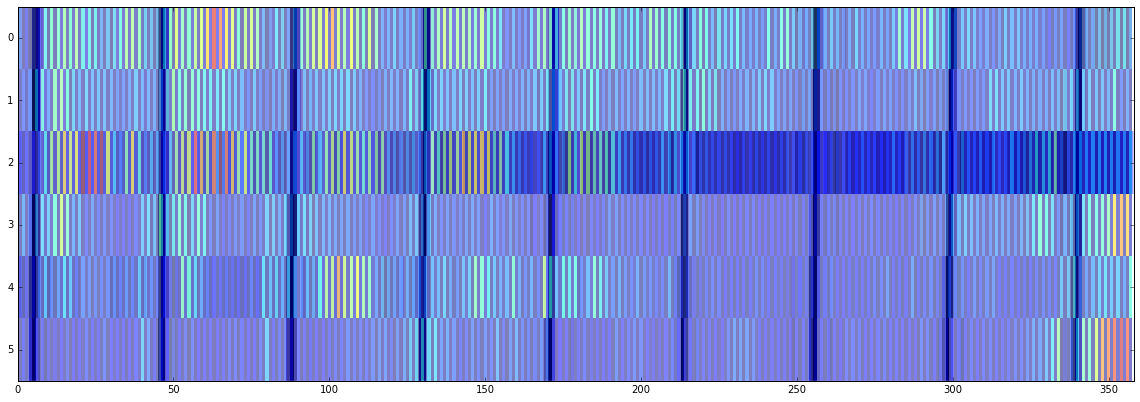

In [163]:
print nScans
image_array = get_matrix(binned_data,len(bins),nScans)
nrows,ncols,nbins = image_array.shape
plt.figure(figsize=(20,20))
plt.imshow(image_array[:,:,156],aspect=20,interpolation='None')
im_small = im[0::17,:]
print im_small.shape
plt.imshow(im_small,alpha=0.5,aspect=20,extent=[0,ncols,5.5,-0.5],interpolation='None')


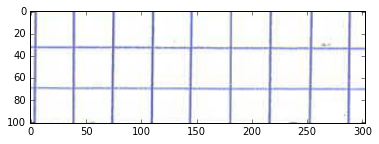

In [90]:
im = plt.imread('/Users/simon/Dropbox/MS_Ink_Data/Amino Acids/grid.png')
plt.imshow(im,alpha=0.6)

Try just mapping each spectrum to an x,y co-ordinate (in mm)

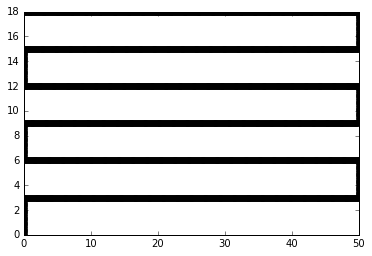

In [344]:
# Starting positions
xpos = 0
ypos = 0
class Pixel(object):
    def __init__(self,x,y,spc_id):
        self.col = x
        self.row = y
        self.spec_id = spec_id

n_rows = 6.0
time_between_scans = 1.25 # seconds
row_length = 50.0 # mm
drop_height = 3.0 # mm
total_distance = (row_length + drop_height) * n_rows
robot_speed = 1.0*total_distance/(nScans*time_between_scans)

# robot_speed = 7.0/60.0 # mm per second


scans_per_row = round(nScans / n_rows)
row_scans = round(scans_per_row * row_length / (row_length + drop_height))
rowcoord = []
colcoord = []
for spec_id in range(nScans+1):
    time_elapsed = spec_id * time_between_scans
    distance_traveled = time_elapsed * robot_speed
    row_id = distance_traveled // (row_length + drop_height)
    current_row = row_id * drop_height
    current_col = distance_traveled % (row_length + drop_height)
    if current_col > 50.0:
        current_row += current_col - 50.0
        current_col = 50.0
    if int(row_id) % 2 == 1:
        current_col = 50.0 - current_col
    rowcoord.append(nrows*drop_height - current_row)
    colcoord.append(current_col)
    
    
plt.figure()
plt.plot(np.array(colcoord),np.array(rowcoord),'ko')


In [345]:
def hit(m1,m2,tol):
    if 1e6*abs(m1-m2)/m1 < tol:
        return True
    else:
        return False

In [346]:
def get_intense(mass,ppm,aa_file):
    run = pymzml.run.Reader(aa_file, MS1_Precision=5e-6)
    nScans = run.getSpectrumCount()
    print "Loaded {} scans".format(nScans)
    
    pos = 0
    intense = []
    for spectrum in run:
        h_i = 0.0
        for m,i in spectrum.peaks:
            if hit(m,mass,ppm):
                h_i += i
        pos += 1
        intense.append(h_i)
    return intense
        
hist_intense = get_intense(156.0768,5,aa_file)
phe_intense = get_intense(166.0863,5,aa_file)
arg_intense = get_intense(175.1190,5,aa_file)
pro_intense = get_intense(116.0706,5,aa_file)
leu_inrense = get_intense(132.1019,5,aa_file)

Loaded 2281 scans
Loaded 2281 scans
Loaded 2281 scans
Loaded 2281 scans
Loaded 2281 scans


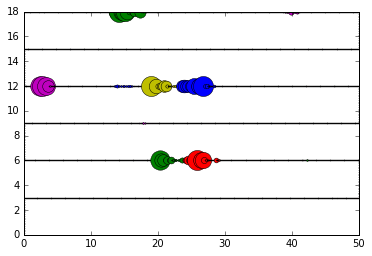

In [347]:
maxi = max(hist_intense)
maxp = max(pro_intense)
maxa = max(arg_intense)
max_ph = max(phe_intense)
max_l = max(leu_intense)
plt.figure()
for pos,i in enumerate(hist_intense):
    x = colcoord[pos]
    y = rowcoord[pos]
    plt.plot(x,y,'ko',markersize=1)
    r_val = i/maxi
    if r_val > 0:
        plt.plot(x,y,'ro',markersize=20.0*r_val)

    r_val = pro_intense[pos]/maxp
    if r_val > 0:
        plt.plot(x,y,'bo',markersize=20.0*r_val)

    r_val = arg_intense[pos]/maxa
    if r_val > 0:
        plt.plot(x,y,'go',markersize=20.0*r_val)

    r_val = phe_intense[pos]/max_ph
    if r_val > 0:
        plt.plot(x,y,'yo',markersize=20.0*r_val)

    r_val = leu_intense[pos]/max_l
    if r_val > 0:
        plt.plot(x,y,'mo',markersize=20.0*r_val)




    

Make the co-ordinates into an image with a particular resolution

In [367]:
def make_image(intense,rowcoord,colcoord,x_start = 0,x_end = 50,x_step=1,y_start=0,y_end=18,y_step=3):
    x_lower_vals = np.arange(x_start,x_end,x_step)
    y_lower_vals = np.arange(y_start,y_end,y_step)

    n_x = len(x_lower_vals)
    n_y = len(y_lower_vals)

    image = np.zeros((n_y,n_x),np.float)

    for k,yc in enumerate(rowcoord):
        if yc > y_lower_vals[-1]:
            y_in = n_y-1
        elif yc == y_lower_vals[0]:
            y_in = y_lower_vals[0]
        else:
            y_in = np.where(yc > y_lower_vals)[0][-1]
        xc = colcoord[k]
        if xc > x_lower_vals[-1]:
            x_in = n_x - 1
        elif xc == x_lower_vals[0]:
            x_in = x_lower_vals[0]
        else:
            x_in = np.where(xc > x_lower_vals)[0][-1]
        image[n_y-y_in-1,x_in] += intense[k]
    return image

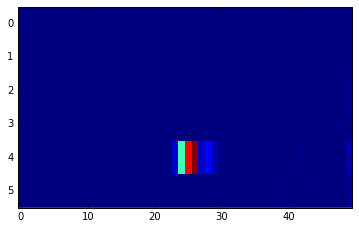

In [377]:
plt.imshow(make_image(hist_intense,rowcoord,colcoord),interpolation='none',aspect=5)
# plt.imshow(make_image(arg_intense,rowcoord,colcoord),interpolation='none',aspect=5)

Try some word selection

In [437]:
min_intense = 500.0 # Peaks below this level are ignored
run = pymzml.run.Reader(aa_file, MS1_Precision=5e-6)
total_peaks = 0.0
unique_peaks = []
instances = []
tol = 10 # ppm
spec_pos = 0
for spectrum in run:
    if spec_pos % 2 == 0:
        for m,i in spectrum.peaks:
            if i >= min_intense:
                if len(unique_peaks) == 0:
                    unique_peaks.append(m)
                    instances.append(1)
                    continue
                total_peaks += 1
#                 try:
#                     idx = (idx for idx,ma in enumerate(unique_peaks) if hit(m,ma,tol)).next()
#                     instances[idx] += 1
#                 except:
                idx = (np.abs(m-np.array(unique_peaks))).argmin()
                if not hit(m,unique_peaks[idx],tol):
                    unique_peaks.append(m)
                    instances.append(1)
                else:
                    instances[idx] += 1
    if spec_pos % 100 == 0:
        print spec_pos,len(unique_peaks)
    spec_pos += 1
        

            

0 233
100 2562
200 2686
300 2887
400 3174
500 3188
600 3199
700 3210
800 3465
900 3714
1000 3815
1100 4087
1200 4777
1300 4778
1400 4837
1500 4853
1600 4864
1700 4977
1800 5037
1900 5366
2000 5501
2100 5503
2200 5510


In [438]:
min_occurance = 10
word_names = []
word_masses = []
for i,u in enumerate(unique_peaks):
    if instances[i] >= min_occurance:
        word_masses.append(u)
        word_names.append(str(u))
print "Resulted in {} words".format(len(word_names))
word_masses = np.array(word_masses)

Resulted in 3072 words


make the documents

In [460]:
run = pymzml.run.Reader(aa_file, MS1_Precision=5e-6)
norm_intense_to = 100
sid = 0
corpus = {}
for spectrum in run:
    new_doc = {}
    max_i = 0.0
    if sid % 2 == 0:
        for m,i in spectrum.peaks:
            if i > min_intense:
                # try and match the peak to a word
                idx = (np.abs(m - word_masses)).argmin()
                if hit(m,word_masses[idx],tol):
                    new_doc[word_names[idx]] = round(i/100.0)
            if i> max_i:
                max_i = i
    corpus[str(sid)] = new_doc
#     for word in new_doc:
#         new_doc[word] = round(norm_intense_to * new_doc[word]/max_i)
    if sid % 100 == 0:
        print sid
    sid += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


As a test, find the histidine word

175.120361911


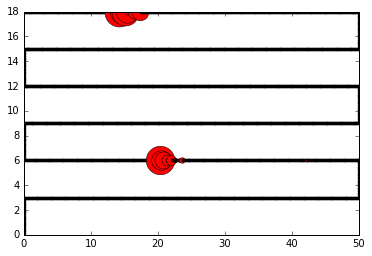

In [461]:
hist_idx = (np.abs(175.1190 - word_masses)).argmin()
print word_names[hist_idx]
plt.figure()
for i,y in enumerate(rowcoord):
    thisdoc = corpus[str(i)]
    h_i = thisdoc.get(word_names[hist_idx],0.0)
    x = colcoord[i]
    plt.plot(x,y,'k.')
    if h_i > 0.0:
        plt.plot(x,y,'ro',markersize=h_i/2)

3.51358457493
